# Machine Learning on Geospatial Data

Aviandito, 2020

* Spatial cross validation: https://arxiv.org/pdf/1803.11266.pdf
* Explore Australia challenge: https://unearthed.solutions/u/challenge/evergreen/generate-new-knowledge-predicting-all-australian-mineral-deposits
* Explore Australia GitHub repo: https://github.com/unearthed/explore_australia
* PySpatialML GitHub repo: https://github.com/stevenpawley/Pyspatialml
* PySpatialML test notebook: https://github.com/stevenpawley/Pyspatialml/blob/master/examples/meuse_example.ipynb 

In [1]:
from explore_australia.stamp import Stamp, get_coverages
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from pyspatialml import Raster
from pyspatialml.preprocessing import xy_coordinates, distance_to_corners
import rasterio.plot
from pyproj import CRS

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%config InlineBackend.figure_format ='retina'

In [2]:
def plot_stack(pyspatialml_stack, width = 20, height = 20):
    fig = plt.figure(figsize=(width, height))

    cols = int(np.sqrt(pyspatialml_stack.count))
    rows = int(np.ceil(np.sqrt(pyspatialml_stack.count)))

    if rows * cols < pyspatialml_stack.count:
        cols += 1

    ax = []

    for i in range(len(pyspatialml_stack.names)):
        ax.append(fig.add_subplot(rows, cols, i+1))
        ax[-1].set_title(pyspatialml_stack.names[i])
        plt.imshow(pyspatialml_stack.iloc[i].read(masked=True),
                   extent = rasterio.plot.plotting_extent(pyspatialml_stack.iloc[i]))
        plt.colorbar()

## Get raster data

In [3]:
stamp = Stamp(lat=-31.125, lon=121.75, distance=100)

In [4]:
get_coverages(
        name='feysville',  # a name for the data/stamp area
        stamp=stamp,
        no_crs=False,           # if true, will remove the CRS info
        show_progress=True
    )

Failed to get http://dap-wms.nci.org.au/thredds/wcs/wx7/aster/vnir/Aus_Mainland/Aus_Mainland_AlOH_group_composition_reprojected.nc4 for (POINT (121.75 -31.125))
Failed to get http://dap-wms.nci.org.au/thredds/wcs/wx7/aster/vnir/Aus_Mainland/Aus_Mainland_Ferrous_Iron_Index_reprojected.nc4 for (POINT (121.75 -31.125))
Failed to get http://dap-wms.nci.org.au/thredds/wcs/wx7/aster/vnir/Aus_Mainland/Aus_Mainland_Opaque_Index_reprojected.nc4 for (POINT (121.75 -31.125))
Failed to get http://dap-wms.nci.org.au/thredds/wcs/wx7/aster/vnir/Aus_Mainland/Aus_Mainland_MgOH_group_content_reprojected.nc4 for (POINT (121.75 -31.125))


## Load raster data

In [26]:
path = 'feysville'

predictor_filename = []

for root, dirs, files in os.walk(path):
    for filename in files:
        predictor_filename.append(os.path.join(root, filename))

predictor_filename[1]

'feysville/remote_sensing/aster/ferric_oxide_content.tif'

In [27]:
stack = Raster(predictor_filename)

# reproject to WGS84 because idk whats happening with the original raster's projection :((
crs_wgs84 = CRS({'init': 'epsg:4326'})
stack = stack.to_crs(crs = crs_wgs84)

stack.names[1]

'ferric_oxide_content'

/opt/anaconda3/envs/explore_australia/lib/python3.6/site-packages/matplotlib/image.py:443: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)
/opt/anaconda3/envs/explore_australia/lib/python3.6/site-packages/matplotlib/image.py:421: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


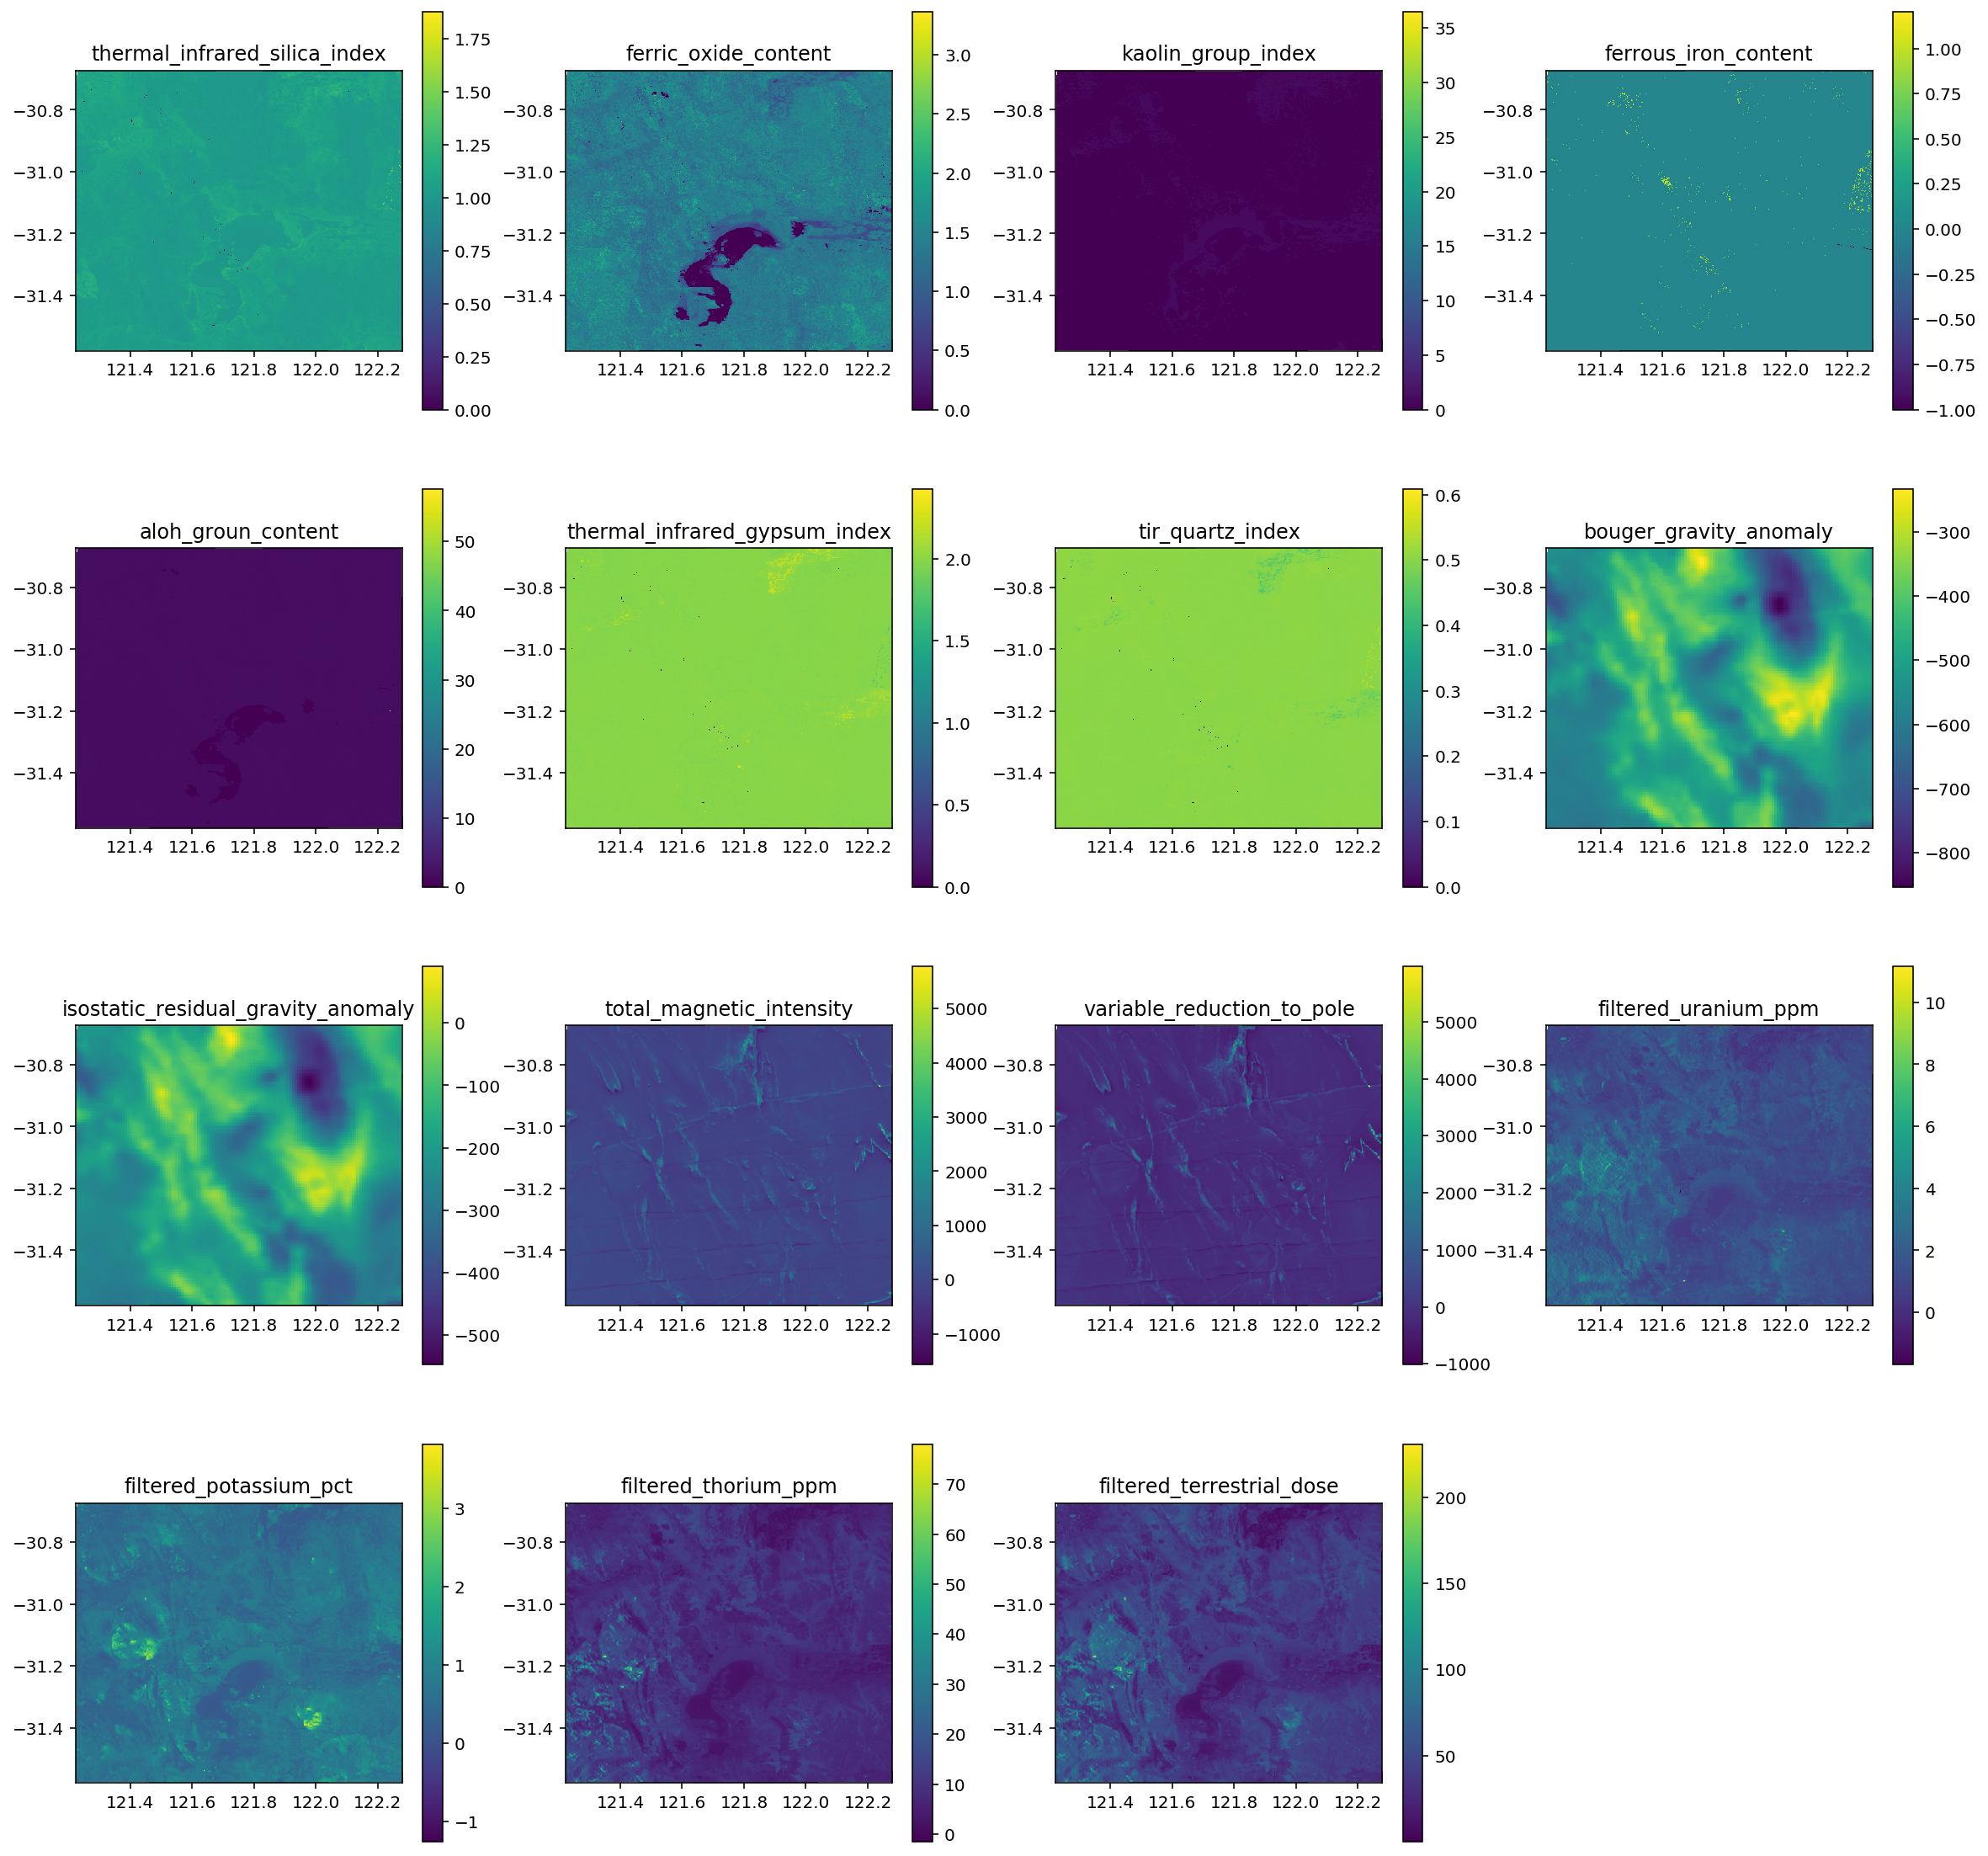

In [28]:
plot_stack(stack)
plt.show()

## Generate geolocation feature using Pyspatialml's built in functions

In [29]:
xy_grids = xy_coordinates(layer = stack.iloc[0])
edm_grids = distance_to_corners(layer = stack.iloc[0])

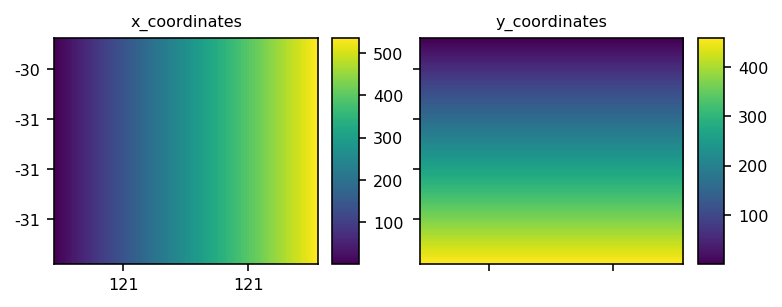

In [30]:
xy_grids.plot()
plt.show()

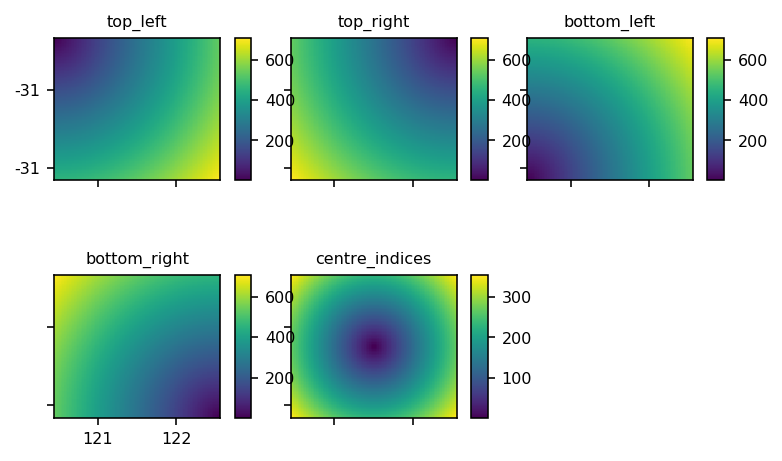

In [31]:
edm_grids.plot()
plt.show()

In [32]:
stack_fin = stack
stack_fin.append(xy_grids)
stack_fin.append(edm_grids)

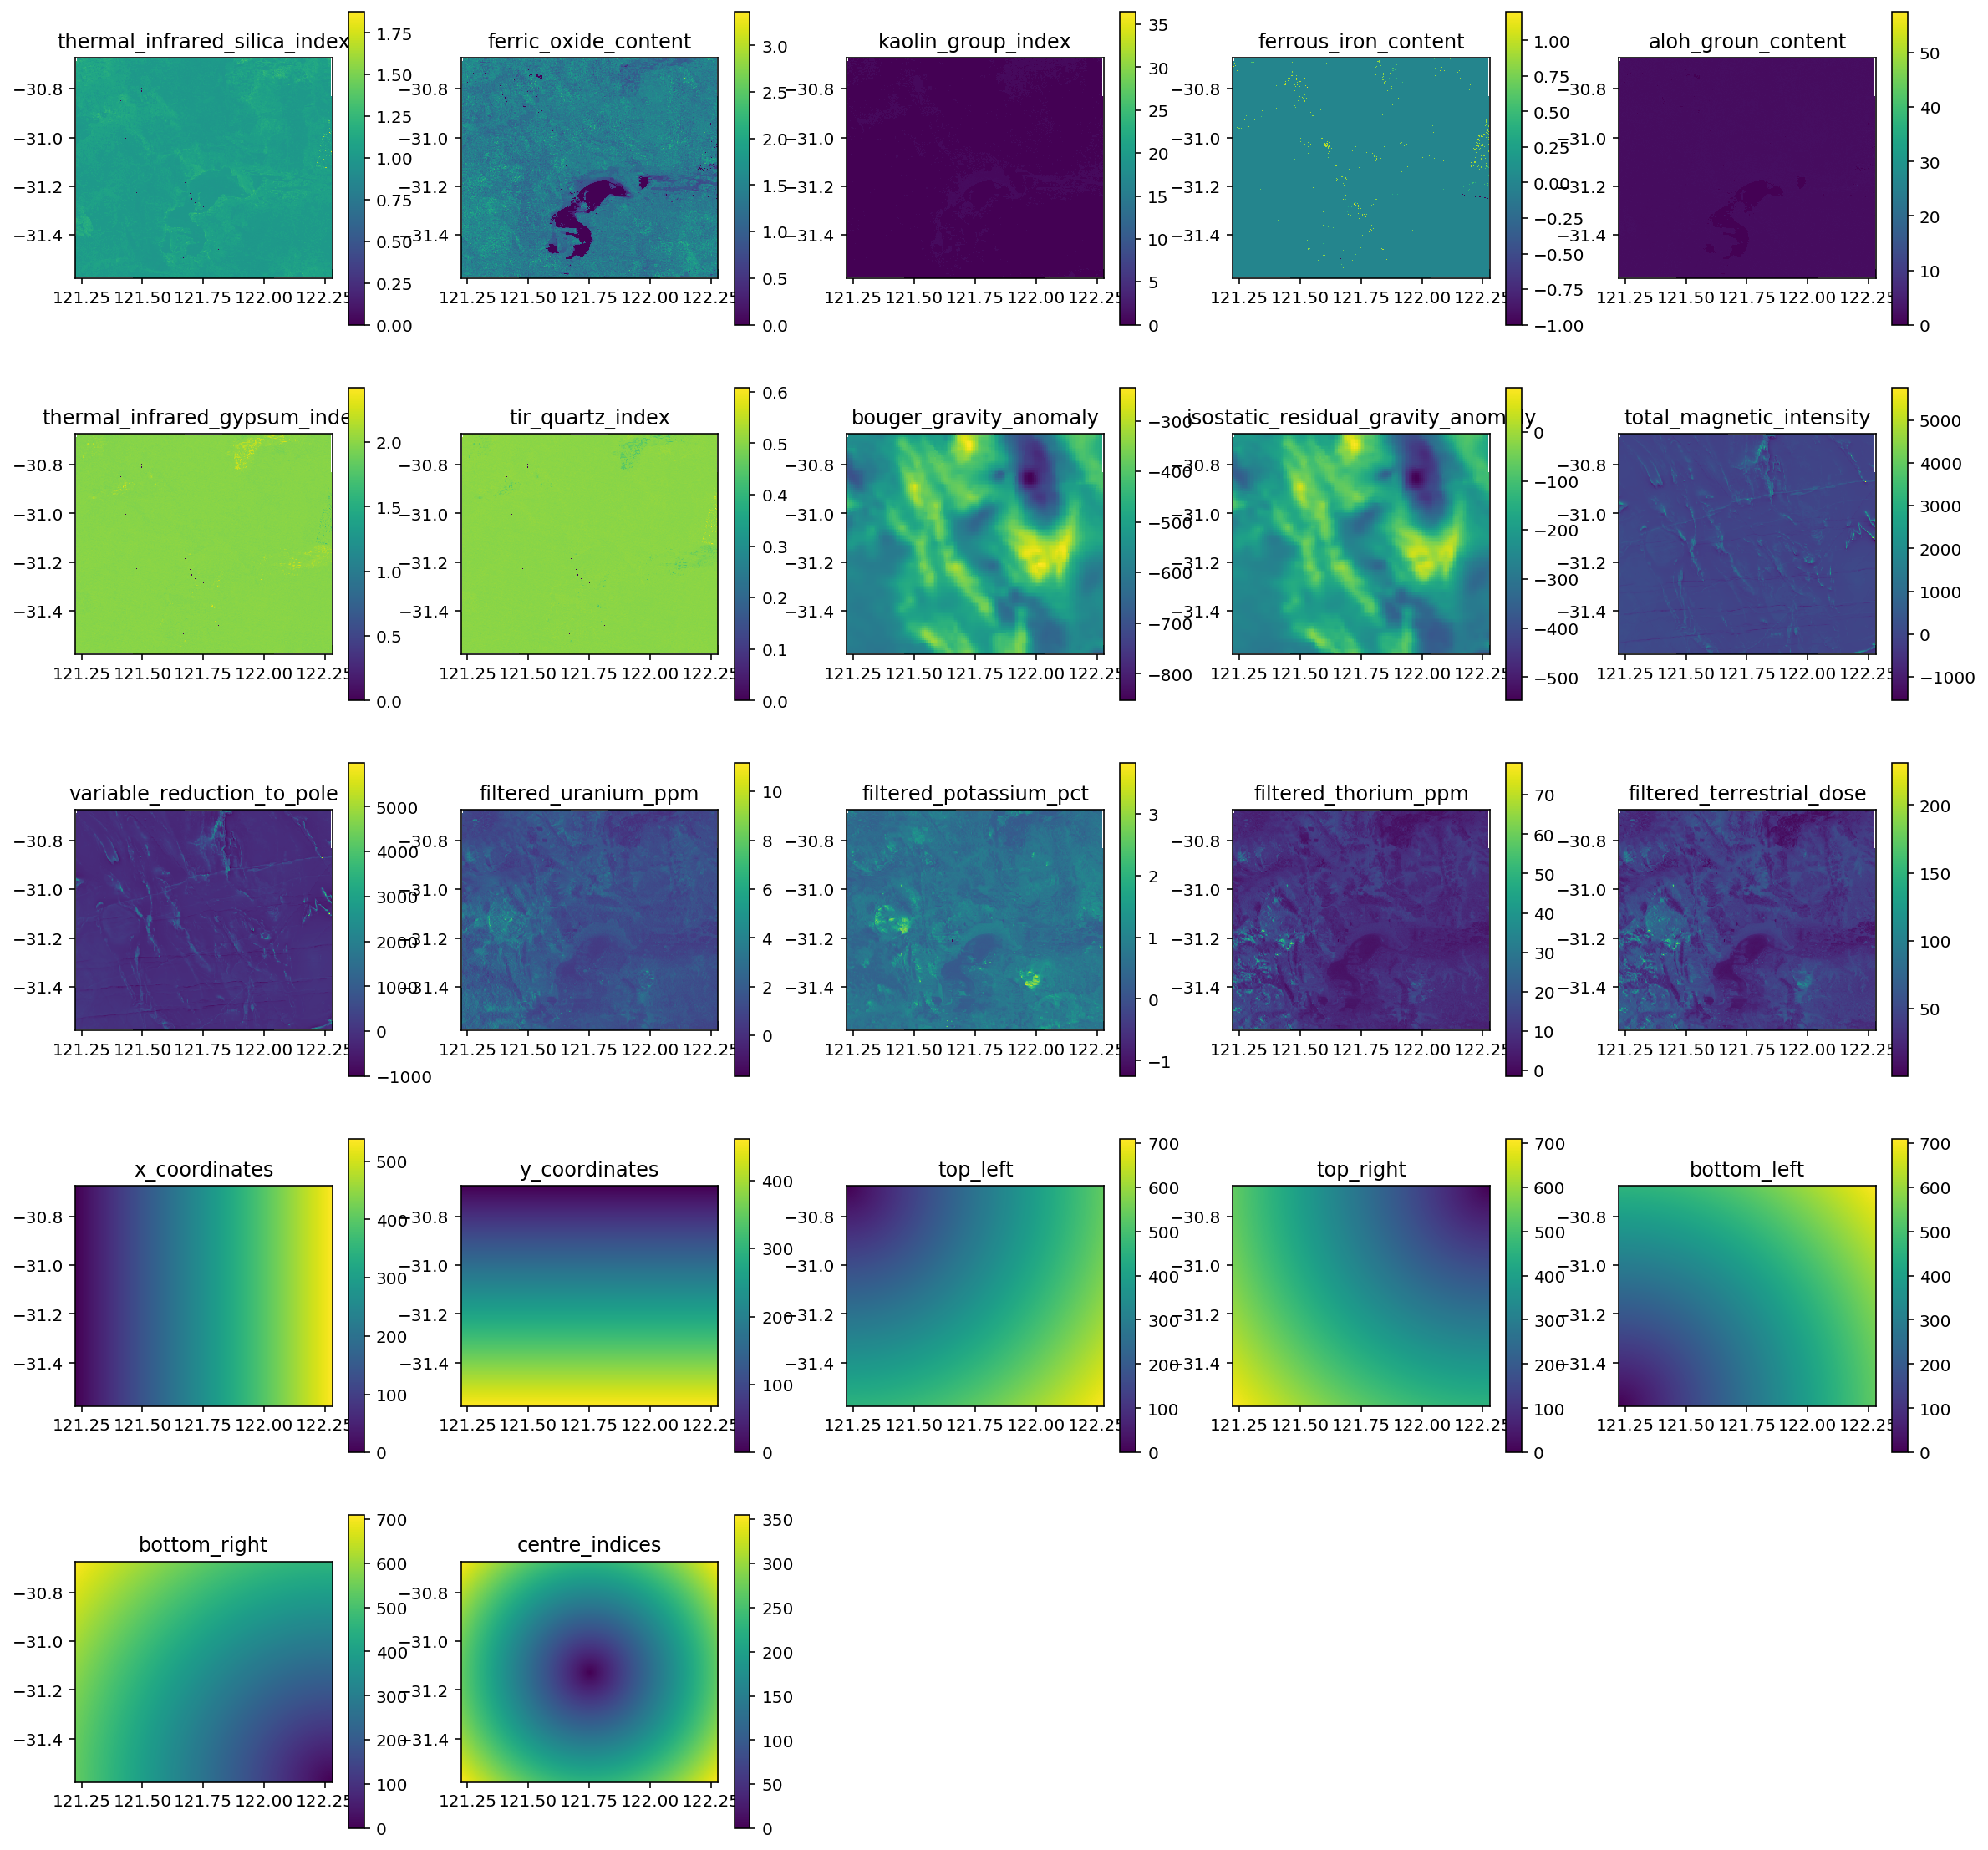

In [33]:
plot_stack(stack_fin)
plt.show()

## Load deposit data

In [34]:
data = '../data/deposit_locations.geo.json'
deposits = gpd.read_file(data)

# subset deposits data to raster bounding box
xmin, xmax, ymin, ymax = rasterio.plot.plotting_extent(stack_fin.bouger_gravity_anomaly)
deposits = deposits.cx[xmin:xmax, ymin:ymax]

deposits.head()

age                                            comment  \
8   Archaean                                                nan   
32      None  B4upd<500m(5):-Deposit Located Northeast Of Or...   
34      None                                   B4upd<10km(.6):-   
44   Archean                                                nan   
99  Archaean                                        2660-2620Ma   

   commodities_string      id   latitude   longitude          name  \
8                  Au  333294 -31.045200  122.212300      Randalls   
32                 Ni  333328 -31.182255  121.457035   East Scotia   
34                 Au  333330 -31.551741  121.740354          Duke   
44                 Au  333346 -30.825600  121.391900  Navajo Chief   
99                 Au  333419 -31.316737  121.775646     Santa Ana   

                       geometry  
8   POINT (122.21230 -31.04520)  
32  POINT (121.45704 -31.18226)  
34  POINT (121.74035 -31.55174)  
44  POINT (121.39190 -30.82560)  
99  POINT (121.77565 -31.31674)

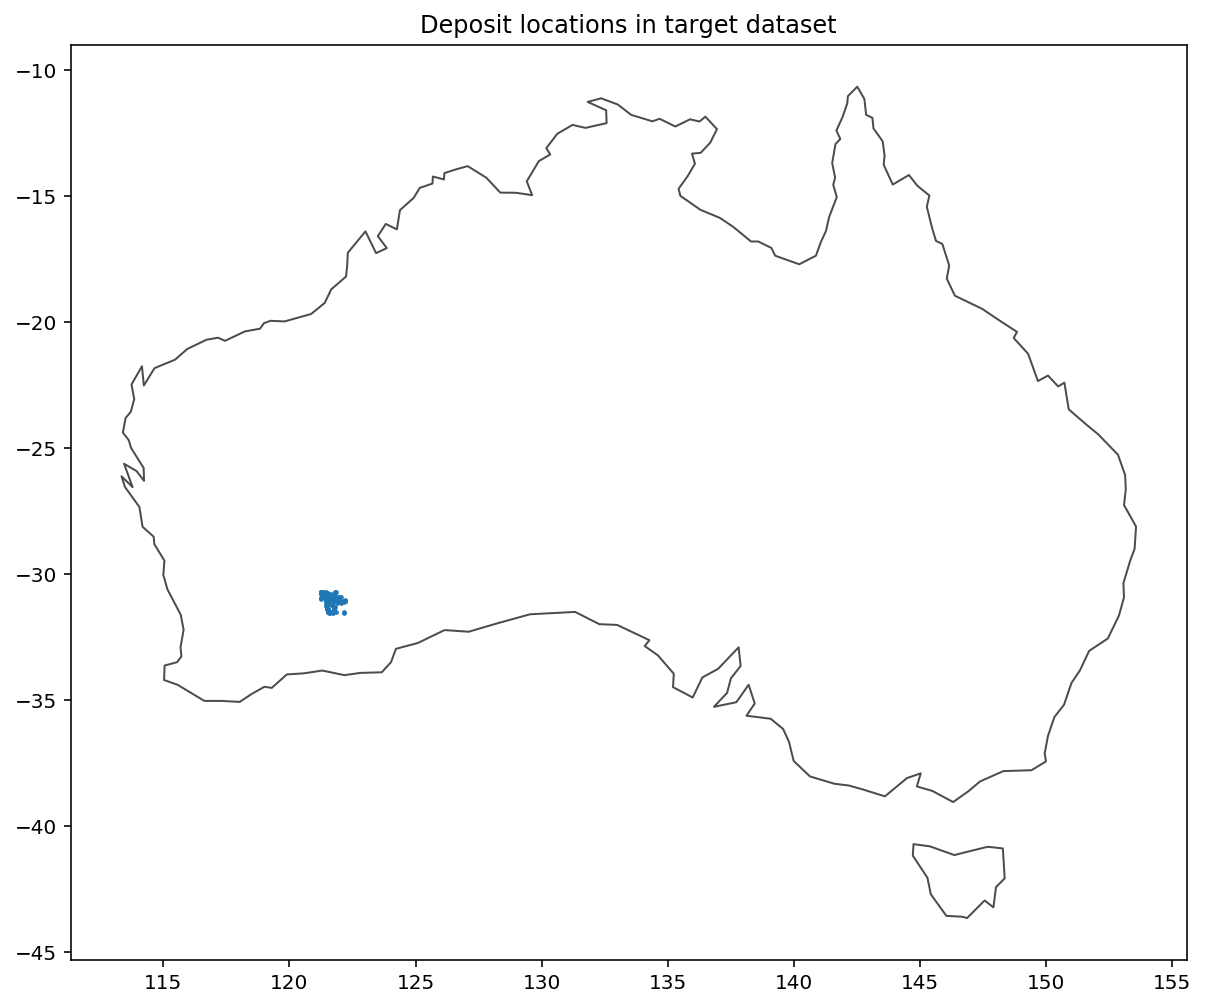

In [35]:
# get Aussie lowres plot
path = gpd.datasets.get_path('naturalearth_lowres')
earth = gpd.read_file(path)
australia = earth[earth['name'] == 'Australia']

# plot deposits location
f, ax = plt.subplots(1, 1)
f.set_size_inches(10, 10)
australia.plot(edgecolor='black', facecolor='white', alpha=0.7, ax=ax)
deposits.plot(markersize=2, alpha=0.9, ax=ax)
ax.set_title('Deposit locations in target dataset')
plt.show()

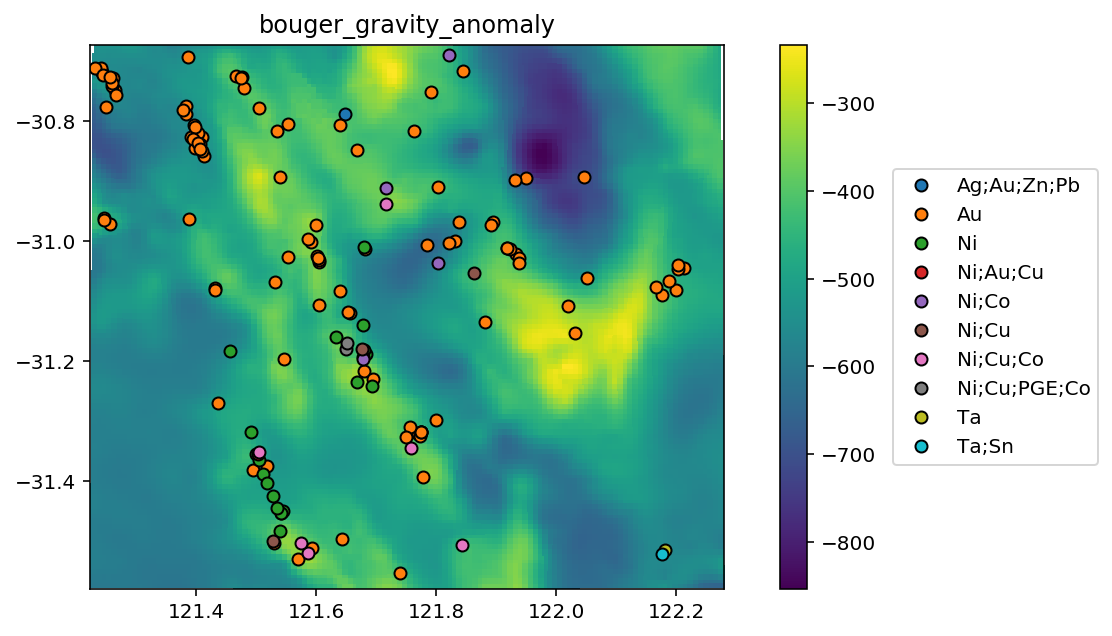

In [36]:
plt.figure(figsize=(10, 5))

plt.title('bouger_gravity_anomaly')

plt.imshow(stack_fin.bouger_gravity_anomaly.read(masked=True),
           extent = rasterio.plot.plotting_extent(stack_fin.bouger_gravity_anomaly))
plt.colorbar()

groups = deposits.groupby("commodities_string")
for name, group in groups:
    plt.plot(group['longitude'], group['latitude'], marker="o", linestyle="", label=name, mec = 'black')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

plt.show()

In [37]:
# look for unique deposit in commodities_string to one hot encode
depo_string = deposits.commodities_string.unique()

sublisted = [x.split(';') for x in depo_string]

all_depo = []
for sublist in sublisted:
    for depo in sublist:
        all_depo.append(depo)
        
unique_depo = np.unique(all_depo)

unique_depo

array(['Ag', 'Au', 'Co', 'Cu', 'Ni', 'PGE', 'Pb', 'Sn', 'Ta', 'Zn'],
      dtype='<U3')

In [38]:
# OHE for each commodities
for depo in unique_depo:
    deposits['is_' + depo] = [1 if depo in row else 0 for row in deposits['commodities_string']]

deposits.head()

age                                            comment  \
8   Archaean                                                nan   
32      None  B4upd<500m(5):-Deposit Located Northeast Of Or...   
34      None                                   B4upd<10km(.6):-   
44   Archean                                                nan   
99  Archaean                                        2660-2620Ma   

   commodities_string      id   latitude   longitude          name  \
8                  Au  333294 -31.045200  122.212300      Randalls   
32                 Ni  333328 -31.182255  121.457035   East Scotia   
34                 Au  333330 -31.551741  121.740354          Duke   
44                 Au  333346 -30.825600  121.391900  Navajo Chief   
99                 Au  333419 -31.316737  121.775646     Santa Ana   

                       geometry  is_Ag  is_Au  is_Co  is_Cu  is_Ni  is_PGE  \
8   POINT (122.21230 -31.04520)      0      1      0      0      0       0   
32  POINT (121.45704 -31.18226)      0      0      0      0      1       0   
34  POINT (121.74035 -31.55174)      0      1      0      0      0       0   
44  POINT (121.39190 -30.82560)      0      1      0      0      0       0   
99  POINT (121.77565 -31.31674)      0      1      0      0      0       0   

    is_Pb  is_Sn  is_Ta  is_Zn  
8       0      0      0      0  
32      0      0      0      0  
34      0      0      0      0  
44      0      0      0      0  
99      0      0      0      0

In [39]:
deposits[deposits['is_Ag']==1]

age comment commodities_string      id  latitude  longitude  \
1107  Archaean     nan        Ag;Au;Zn;Pb  334860  -30.7887   121.6479   

        name                     geometry  is_Ag  is_Au  is_Co  is_Cu  is_Ni  \
1107  Nimbus  POINT (121.64790 -30.78870)      1      1      0      0      0   

      is_PGE  is_Pb  is_Sn  is_Ta  is_Zn  
1107       0      1      0      0      1

# Prepare data for machine learning workflow

In [40]:
training_df = stack_fin.extract_vector(deposits, columns=['is_Au', 'is_Ni', 'is_Ag', 'is_Co', 'is_Cu', 'is_PGE', 'is_Pb', 'is_Sn', 'is_Ta', 'is_Zn'])
training_df = training_df.dropna()
training_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   is_Au                               150 non-null    float64 
 1   is_Ni                               150 non-null    float64 
 2   is_Ag                               150 non-null    float64 
 3   is_Co                               150 non-null    float64 
 4   is_Cu                               150 non-null    float64 
 5   is_PGE                              150 non-null    float64 
 6   is_Pb                               150 non-null    float64 
 7   is_Sn                               150 non-null    float64 
 8   is_Ta                               150 non-null    float64 
 9   is_Zn                               150 non-null    float64 
 10  thermal_infrared_silica_index       150 non-null    float32 
 11  ferric_oxide_content    

In [41]:
training_df.head()

is_Au  is_Ni  is_Ag  is_Co  is_Cu  is_PGE  is_Pb  is_Sn  is_Ta  is_Zn  ...  \
0    1.0    0.0    0.0    0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    1.0    0.0    0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
2    1.0    0.0    0.0    0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
3    1.0    0.0    0.0    0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
4    1.0    0.0    0.0    0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   

   filtered_thorium_ppm  filtered_terrestrial_dose  x_coordinates  \
0              6.752796                  41.848576          504.0   
1             13.804704                  74.140564          119.0   
2              6.576898                  30.993452          263.0   
3             13.859620                  68.966454           86.0   
4              5.834911                  32.240986          281.0   

   y_coordinates    top_left   top_right  bottom_left  bottom_right  \
0          189.0  538.272217  192.033844   572.712830    274.116760   
1          259.0  285.029816  492.587036   234.446152    465.150513   
2          448.0  519.493042  525.670044   263.321106    275.307098   
3           77.0  115.433968  458.511719   393.512390    593.093567   
4          328.0  431.908569  416.692932   310.885834    289.375183   

   centre_indices                     geometry  
0      238.723694  POINT (122.21230 -31.04520)  
1      152.590958  POINT (121.45704 -31.18226)  
2      217.082932  POINT (121.74035 -31.55174)  
3      239.175674  POINT (121.39190 -30.82560)  
4       97.739449  POINT (121.77565 -31.31674)  

[5 rows x 33 columns]

In [79]:
clf = RandomForestClassifier(random_state = 123)

# fit the classifier
X = training_df.drop(columns=['is_Au', 'is_Ni','is_Ag', 'is_Co', 'is_Cu', 'is_PGE', 'is_Pb', 'is_Sn', 'is_Ta', 'is_Zn', 'geometry'])
y = training_df.is_Au
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [80]:
# Spatial cross validation w/ k-means
# create 10 spatial clusters based on clustering of the training point x,y coordinates

clusters = KMeans(n_clusters=10, random_state = 123)
clusters.fit(training_df.geometry.bounds.iloc[:, 0:2])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

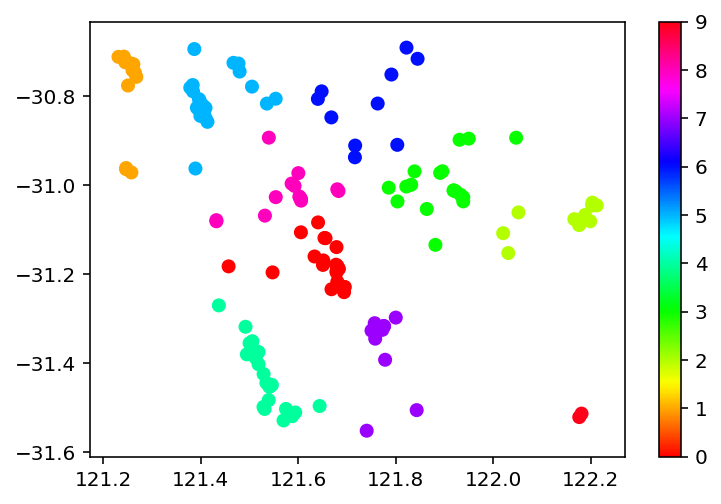

In [81]:
points = training_df.geometry.bounds.iloc[:, 0:2]
points['cluster'] = clusters.labels_

plt.scatter(x = points.minx, y = points.miny, c = points.cluster, cmap = 'hsv')
plt.colorbar()
plt.show()

In [85]:
# cross validate
scores = cross_validate(
  clf, X, y, groups=clusters.labels_,
  scoring='accuracy',
  cv=10)

scores['test_score'].mean()

0.7999999999999999

In [86]:
# prediction on raster stacks
result_probs = stack_fin.predict_proba(estimator=clf, nodata=0)

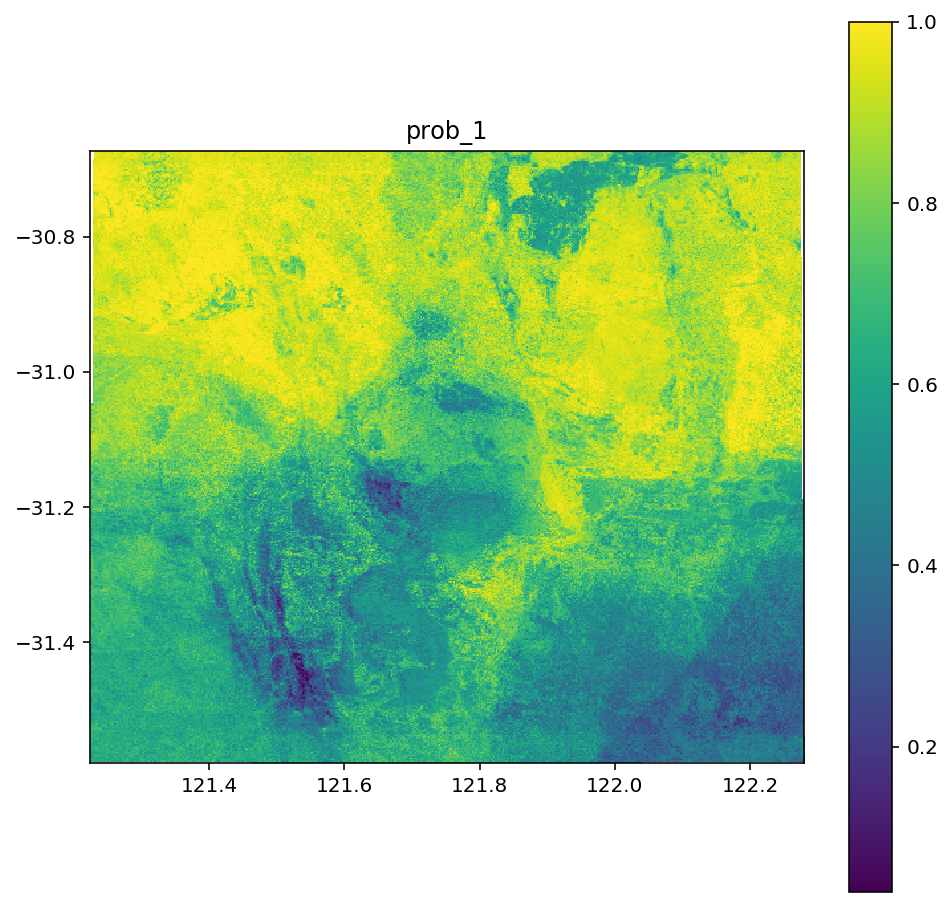

In [87]:
# plot the probability of Au occurence based on the model
result_probs.drop('prob_0')

plot_stack(result_probs, width = 8, height = 8)
plt.show()

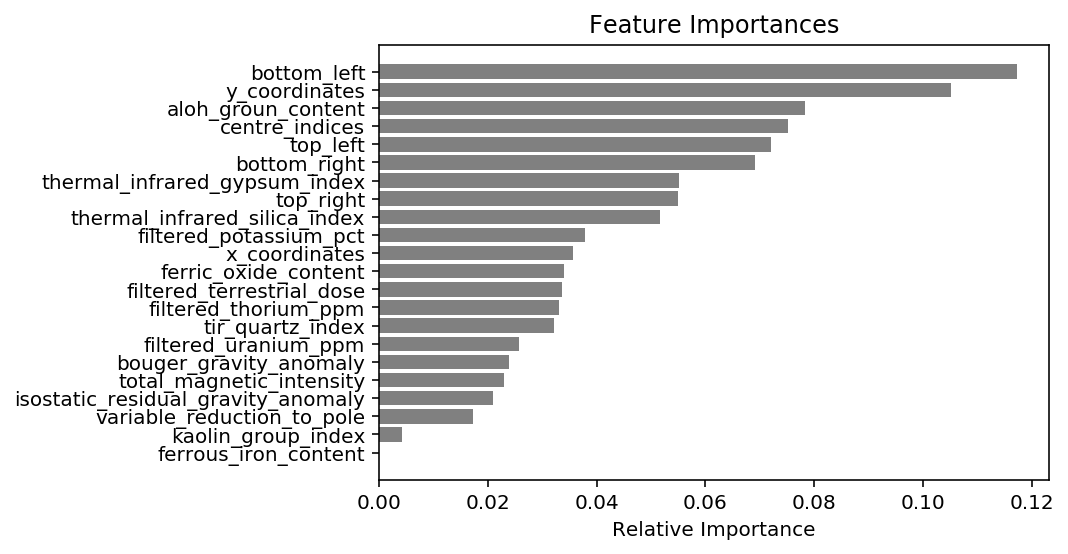

In [88]:
features = stack_fin.names
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='grey', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()